In [28]:
# 1
import numpy as np
import matplotlib.pyplot as plt

# Define the helical quadrupole transfer matrices
def helical_quadrupole_matrix(L, k):
    cos_kl = np.cos(k * L)
    sin_kl = np.sin(k * L)
    M_x = np.array([[cos_kl, sin_kl/k, 0, 0],
                    [-k*sin_kl, cos_kl, 0, 0],
                    [0, 0, 1, 0],
                    [0, 0, 0, 1]])
    M_y = np.array([[1, 0, 0, 0],
                    [0, 1, 0, 0],
                    [0, 0, cos_kl, sin_kl/k],
                    [0, 0, -k*sin_kl, cos_kl]])
    return M_x, M_y



L = 0.5 
k = 3.9

M_x, M_y = helical_quadrupole_matrix(L/num_steps, k)



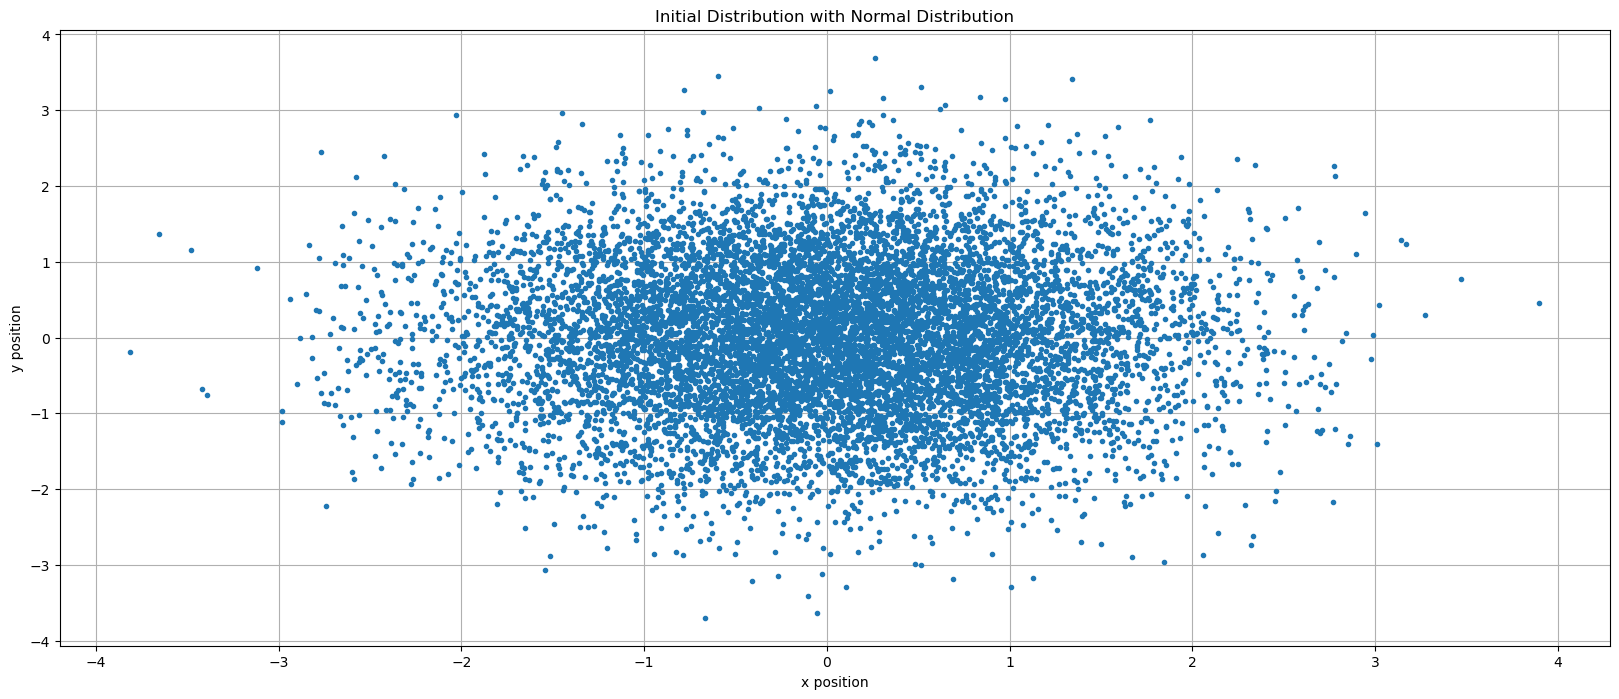

In [29]:
# 2
import numpy as np
import matplotlib.pyplot as plt

# Define the number of particles and the standard deviations (sigma values)
num_particles = 10000
sigma_x = 1.0  # Assumed value for standard deviation of x
sigma_y = 1.0  # Assumed value for standard deviation of y
sigma_x2 = 0.1  # Assumed value for standard deviation of x'
sigma_y2 = 0.1  # Assumed value for standard deviation of y'

# Define the initial matrix based on sigma x and sigma y using a normal distribution
initial_positions = np.zeros((num_particles, 4))
initial_positions[:, 0] = np.random.normal(0, sigma_x, num_particles)  # x positions
initial_positions[:, 1] = np.random.normal(0, sigma_x2, num_particles)  # x' positions
initial_positions[:, 2] = np.random.normal(0, sigma_y, num_particles)  # y positions
initial_positions[:, 3] = np.random.normal(0, sigma_y2, num_particles)  # y' positions

# Plotting
plt.figure(figsize=(20,8))
plt.plot(initial_positions[:, 0], initial_positions[:, 2], '.')
plt.xlabel('x position')
plt.ylabel('y position')
plt.title('Initial Distribution with Normal Distribution')
plt.grid(True)
plt.show()


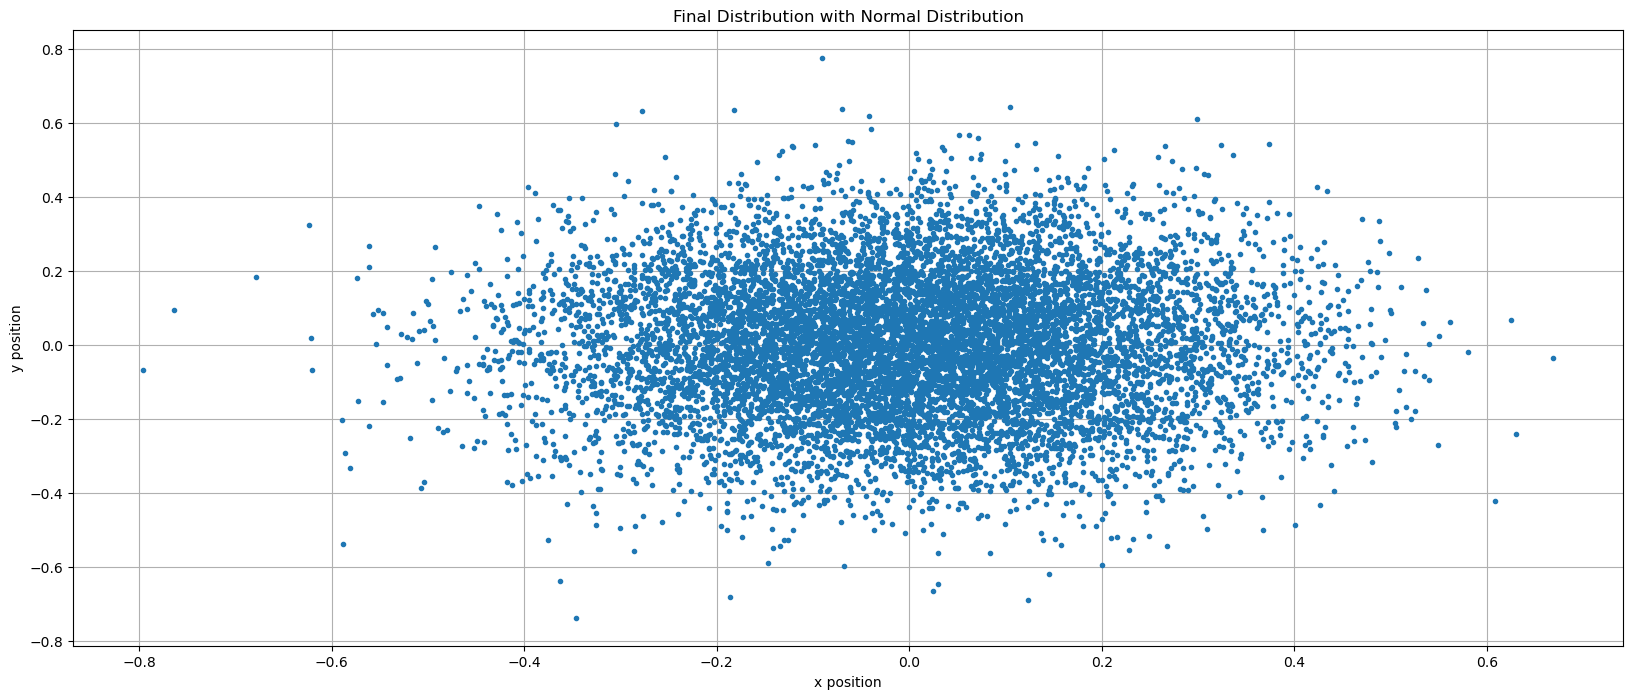

In [22]:
# 3
# Getting the transfer matrices
num_steps = 10
M_x, M_y = helical_quadrupole_matrix(L/num_steps, k)
L = 0.5  
k = 3.9

# Storing positions
positions = np.zeros((num_steps, num_particles, 4))
positions[0] = initial_positions

for step in range(1, num_steps):
    for i in range(num_particles):
        # Update position using matrix multiplication
        positions[step, i, :] = M_y @ (M_x @ positions[step-1, i, :])

# Plotting the final distribution
plt.figure(figsize=(20, 8))
plt.plot(positions[-1, :, 0], positions[-1, :, 2], '.')
plt.xlabel('x position')
plt.ylabel('y position')
plt.title('Final Distribution with Normal Distribution')
plt.grid(True)
plt.show()


In [33]:
# 4
# CALCULATION TWISS PARAMETER BY TRANSFER MATRIX
import numpy as np

def rotation_matrix(k, s):
    angle = k * s / 2  # Main angle ks/2
    cos_angle = np.cos(angle)
    sin_angle = np.sin(angle)
    R = np.array([
        [cos_angle, 0, sin_angle, 0],
        [0, cos_angle, 0, sin_angle],
        [-sin_angle, 0, cos_angle, 0],
        [0, -sin_angle, 0, cos_angle]
    ])
    return R

def sigma_inner_matrix(k, K, A_H, A_L):
    sigma = np.zeros((4, 4))
    
    sigma[0, 0] = ((4 * k**2 + 4 * K) /(k**2)) * A_H**2 + (k**2 / K**2) * A_L**2
    sigma[1, 1] = 16 * (K**2 / k**2) * A_H**2
    sigma[2, 2] = 4 * A_H**2 + ((k**2 - 4 * K) / K**2) * (A_L**2)
    sigma[3, 3] = 4 * A_L**2
    
    sigma[0, 3] = sigma[3, 0] = 2 * (k / K) * A_L**2
    sigma[1, 2] = sigma[2, 1] = 8 * (K / k) * A_H**2
    
    return sigma

def sigma_matrix(k, s, K, A_H, A_L):
    R_plus = rotation_matrix(k, s)  # R(ks/2)
    R_minus = rotation_matrix(-k, s)  # R(-ks/2)
    
    sigma_inner = sigma_inner_matrix(k, K, A_H, A_L)
    print("Sigma Inner Matrix (Transfer):")
    print(sigma_inner)
    
    sigma_final = R_plus @ sigma_inner @ R_minus
    print("Sigma Matrix after applying R+ and R- (Transfer):")
    print(sigma_final)
    return sigma_final

def helical_quadrupole_matrix(L, k):
    cos_kl = np.cos(k * L)
    sin_kl = np.sin(k * L)
    M = np.array([
        [cos_kl, sin_kl / k, 0, 0],
        [-k * sin_kl, cos_kl, 0, 0],
        [0, 0, cos_kl, sin_kl / k],
        [0, 0, -k * sin_kl, cos_kl]
    ])
    return M

def compute_emittance(cov_matrix):
    return np.sqrt(np.linalg.det(cov_matrix))

def compute_twist_parameters(cov_matrix, emittance):
    beta = cov_matrix[0, 0] / emittance
    alpha = -cov_matrix[0, 1] / emittance
    gamma = cov_matrix[1, 1] / emittance
    return beta, alpha, gamma

k = 3.9
K = k**2 / 8

A_L = (2 * K / k) * ((k**2 + 4 * K) / (k**2 - 4 * K))
A_H = (16 * A_L) / (np.sqrt(3) * (k**2))

s = 0.4

print(f"Parameters (Transfer): k = {k}, K = {K}, A_H = {A_H}, A_L = {A_L}")

sigma_initial = sigma_matrix(k, s, K, A_H, A_L)

L = 0.5


M_quad = helical_quadrupole_matrix(L, k)
print("Helical Quadrupole Matrix (Transfer):")
print(M_quad)

sigma_final = M_quad @ sigma_initial @ M_quad.T
print("Final Sigma Matrix (Transfer):")
print(sigma_final)

cov_x_final = sigma_final[:2, :2]
cov_y_final = sigma_final[2:, 2:]

emittance_x_final = compute_emittance(cov_x_final)
beta_x_final, alpha_x_final, gamma_x_final = compute_twist_parameters(cov_x_final, emittance_x_final)

emittance_y_final = compute_emittance(cov_y_final)
beta_y_final, alpha_y_final, gamma_y_final = compute_twist_parameters(cov_y_final, emittance_y_final)

print("\nFinal Twiss Parameters for x-plane (Transfer):")
print(f"Emittance: {emittance_x_final:.4f}")
print(f"Beta: {beta_x_final:.4f}")
print(f"Alpha: {alpha_x_final:.4f}")
print(f"Gamma: {gamma_x_final:.4f}")

print("\nFinal Twiss Parameters for y-plane (Transfer):")
print(f"Emittance: {emittance_y_final:.4f}")
print(f"Beta: {beta_y_final:.4f}")
print(f"Alpha: {alpha_y_final:.4f}")
print(f"Gamma: {gamma_y_final:.4f}")


Parameters (Transfer): k = 3.9, K = 1.9012499999999999, A_H = 1.77646236673731, A_L = 2.925
Sigma Inner Matrix (Transfer):
[[50.20118343  0.          0.         35.1       ]
 [ 0.         12.         12.30769231  0.        ]
 [ 0.         12.30769231 30.62327416  0.        ]
 [35.1         0.          0.         34.2225    ]]
Sigma Matrix after applying R+ and R- (Transfer):
[[ 40.5179115   23.7024647   -9.78838414  11.65206334]
 [ 23.7024647   22.99129164 -11.14024435  11.11060244]
 [ -9.78838414 -11.14024435  40.3065461  -23.7024647 ]
 [ 11.65206334  11.11060244 -23.7024647   23.23120836]]
Helical Quadrupole Matrix (Transfer):
[[-0.37018083  0.2381948   0.          0.        ]
 [-3.62294289 -0.37018083  0.          0.        ]
 [ 0.          0.         -0.37018083  0.2381948 ]
 [ 0.          0.         -3.62294289 -0.37018083]]
Final Sigma Matrix (Transfer):
[[   2.67684007   35.10670895   -0.75609005   -2.8969309 ]
 [  35.10670895  598.55398802  -25.6892386  -126.27059061]
 [  -0.75

In [31]:
# 5
# CALCULATION TWISS PARAMETER BY PARTICLE TRACKING
import numpy as np

def rotation_matrix(k, s):
    angle = k * s / 2  # Main angle ks/2
    cos_angle = np.cos(angle)
    sin_angle = np.sin(angle)
    R = np.array([
        [cos_angle, 0, sin_angle, 0],
        [0, cos_angle, 0, sin_angle],
        [-sin_angle, 0, cos_angle, 0],
        [0, -sin_angle, 0, cos_angle]
    ])
    return R

def sigma_inner_matrix(k, K, A_H, A_L):
    sigma = np.zeros((4, 4))
    
    sigma[0, 0] = ((4 * k**2 + 4 * K) /(k**2)) * A_H**2 + (k**2 / K**2) * A_L**2
    sigma[1, 1] = 16 * (K**2 / k**2) * A_H**2
    sigma[2, 2] = 4 * A_H**2 + ((k**2 - 4 * K) / K**2) * (A_L**2)
    sigma[3, 3] = 4 * A_L**2
    
    sigma[0, 3] = sigma[3, 0] = 2 * (k / K) * A_L**2
    sigma[1, 2] = sigma[2, 1] = 8 * (K / k) * A_H**2
    
    return sigma

def sigma_matrix(k, s, K, A_H, A_L):
    R_plus = rotation_matrix(k, s)
    R_minus = rotation_matrix(-k, s)
    
    sigma_inner = sigma_inner_matrix(k, K, A_H, A_L)
    print("Sigma Inner Matrix (Tracking):")
    print(sigma_inner)
    
    sigma_final = R_plus @ sigma_inner @ R_minus
    print("Sigma Matrix after applying R+ and R- (Tracking):")
    print(sigma_final)
    return sigma_final

def compute_emittance(cov_matrix):
    return np.sqrt(np.linalg.det(cov_matrix))

def compute_twist_parameters(cov_matrix, emittance):
    beta = cov_matrix[0, 0] / emittance
    alpha = -cov_matrix[0, 1] / emittance
    gamma = cov_matrix[1, 1] / emittance
    return beta, alpha, gamma

def track_particles(num_particles, k, s, K, A_H, A_L):
    mean = [0, 0, 0, 0]
    cov = sigma_inner_matrix(k, K, A_H, A_L)
    print("Initial Covariance Matrix (Tracking):")
    print(cov)
    
    initial_conditions = np.random.multivariate_normal(mean, cov, num_particles)
    
    x = initial_conditions[:, 0]
    x_prime = initial_conditions[:, 1]
    y = initial_conditions[:, 2]
    y_prime = initial_conditions[:, 3]
    
    R = rotation_matrix(k, s)
    final_conditions = R @ initial_conditions.T
    
    print("Rotation Matrix (Tracking):")
    print(R)
    
    x_final = final_conditions[0, :]
    x_prime_final = final_conditions[1, :]
    y_final = final_conditions[2, :]
    y_prime_final = final_conditions[3, :]
    
    cov_x = np.cov(x_final, x_prime_final)
    cov_y = np.cov(y_final, y_prime_final)
    
    print("Final Covariance Matrix X (Tracking):")
    print(cov_x)
    print("Final Covariance Matrix Y (Tracking):")
    print(cov_y)
    
    emittance_x = compute_emittance(cov_x)
    beta_x, alpha_x, gamma_x = compute_twist_parameters(cov_x, emittance_x)
    
    emittance_y = compute_emittance(cov_y)
    beta_y, alpha_y, gamma_y = compute_twist_parameters(cov_y, emittance_y)
    
    return (beta_x, alpha_x, gamma_x, emittance_x), (beta_y, alpha_y, gamma_y, emittance_y)

k = 3.9
K = k**2 / 8

A_L = (2 * K / k) * ((k**2 + 4 * K) / (k**2 - 4 * K))
A_H = (16 * A_L) / (np.sqrt(3) * (k**2))

num_particles = 10000
s = 0.4

print(f"Parameters (Tracking): k = {k}, K = {K}, A_H = {A_H}, A_L = {A_L}")

twiss_x, twiss_y = track_particles(num_particles, k, s, K, A_H, A_L)

beta_x, alpha_x, gamma_x, emittance_x = twiss_x
beta_y, alpha_y, gamma_y, emittance_y = twiss_y

print(f"\nFinal Twiss Parameters for x-plane (Tracking):")
print(f"Emittance: {emittance_x:.4f}")
print(f"Beta: {beta_x:.4f}")
print(f"Alpha: {alpha_x:.4f}")
print(f"Gamma: {gamma_x:.4f}")

print(f"\nFinal Twiss Parameters for y-plane (Tracking):")
print(f"Emittance: {emittance_y:.4f}")
print(f"Beta: {beta_y:.4f}")
print(f"Alpha: {alpha_y:.4f}")
print(f"Gamma: {gamma_y:.4f}")


Parameters (Tracking): k = 3.9, K = 1.9012499999999999, A_H = 1.77646236673731, A_L = 2.925
Initial Covariance Matrix (Tracking):
[[50.20118343  0.          0.         35.1       ]
 [ 0.         12.         12.30769231  0.        ]
 [ 0.         12.30769231 30.62327416  0.        ]
 [35.1         0.          0.         34.2225    ]]
Rotation Matrix (Tracking):
[[ 0.71091354  0.          0.70327942  0.        ]
 [ 0.          0.71091354  0.          0.70327942]
 [-0.70327942  0.          0.71091354  0.        ]
 [ 0.         -0.70327942  0.          0.71091354]]
Final Covariance Matrix X (Tracking):
[[41.04595603 24.44818166]
 [24.44818166 23.36622365]]
Final Covariance Matrix Y (Tracking):
[[ 39.91862915 -23.2733773 ]
 [-23.2733773   22.72340079]]

Final Twiss Parameters for x-plane (Tracking):
Emittance: 19.0099
Beta: 2.1592
Alpha: -1.2861
Gamma: 1.2292

Final Twiss Parameters for y-plane (Tracking):
Emittance: 19.1164
Beta: 2.0882
Alpha: 1.2175
Gamma: 1.1887
